In [1]:
%load_ext autoreload
%autoreload

In [2]:
import numpy as np
import pandas as pd
import time
import gc; gc.enable()
import time
import sys

pd.options.display.float_format = "{:.3f}".format
np.set_printoptions(precision=4)

import matplotlib.pyplot as plt
%matplotlib inline

sys.path.append('modules')

from shared_functions import *

import pickle
from datetime import datetime

/home/anaconda/envs/py373/lib/python3.7/site-packages/pyparsing.py:2927: FutureWarning: Possible set intersection at position 3
  self.re = re.compile( self.reString )
/home/anaconda/envs/py373/lib/python3.7/site-packages/sklearn/externals/joblib/__init__.py:15: DeprecationWarning: sklearn.externals.joblib is deprecated in 0.21 and will be removed in 0.23. Please import this functionality directly from joblib, which can be installed with: pip install joblib. If this warning is raised when loading pickled models, you may need to re-serialize those models with scikit-learn 0.21+.
  warnings.warn(msg, category=DeprecationWarning)


In [3]:
# from IPython.core.interactiveshell import InteractiveShell
# InteractiveShell.ast_node_interactivity = "all"

In [4]:
def load_results(file_name):
    data = None
    with open(file_name, 'rb') as f:
        # The protocol version used is detected automatically, so we do not
        # have to specify it.
        data = pickle.load(f)
    return data

def filter_top_model_results(top_models, all_model_results):
    plot_data = list()
    for idx, row in top_models.iterrows():
        #print("row.label: " + row.label + ',' + row.classifier + ',' + row.sampling_method)
        for res in all_model_results:       
            for alg_results in res:
                if alg_results[0] == row.label and alg_results[1] == row.classifier and alg_results[2] == row.sampling_method:
                    #print(alg_results)
                    label, model_name, sampling_method, _, tpr, fpr, roc_auc, precision, recall, prc_auc = alg_results

                    plot_data.append(("{} :: {}".format(model_name, sampling_method), tpr, fpr, roc_auc, precision, recall, prc_auc))
    return plot_data

def rebuild_results(res):
    ## Gather all the metrics
    temp_metrics = pd.DataFrame()
    temp_results = list()
    for i in range(0, len(res)):
        temp_metrics = pd.concat([temp_metrics, res[i][1]])
        temp_results.append(res[i][2]) 
    
    return temp_metrics, temp_results

In [5]:
measurements = ['classifier', 'sampling_method', \
                #'fp', 'fn',\
                'balanced_accuracy', 'recall', 'precision', \
                 #'f1_score',\
                'train_time', 'aucroc', 'auprc',\
                'model_churn_cost']

measurements_alias = ['classifier', 'sampling', \
                      'bal_acc', 'recall', 'precision',\
                      # 'f1',\
                      'train_time', 'auroc', 'auprc',\
                      'churn_cost']

## Summarise performance of the approaches

In [6]:
## First Experiment:
## Approach 1.1 - Churn BasicData + Default Hyper

#exp1_1 = load_results('/home/dissertation/code/RESULTS_FINAL/Basic_DefaultHyper_2019-08-12.pickle')

#exp2_1 = load_results('/home/dissertation/code/RESULTS_FINAL/Manual_GridSearch_2019-08-10.pickle')

#exp2_2 = load_results('/home/dissertation/code/RESULTS_FINAL/Manual_RdmSearch_2019-08-10.pickle')

#exp3_1 = load_results('/home/dissertation/code/RESULTS_FINAL/DFS_Default_2019-08-10.pickle')
exp3_2 = load_results('/home/dissertation/code/RESULTS_FINAL/DFS_RdmSearch_2019-08-18.pickle')

exp_metrics, exp_results = rebuild_results(exp3_2)

In [7]:
#exp_metrics[['classifier', 'sampling_method','accuracy']].groupby(['sampling_method']).count()

In [8]:
exp_metrics.head()

,label,classifier,sampling_method,tn,fn,tp,fp,accuracy,precision,recall,...,log_loss,train_time,cv_time,aucroc,auprc,balanced_accuracy,cv_score_mean,cv_score_std,model_churn_cost,sample
0,NB_dfsrandom_5cv_recall,GaussianNB,None,231265,21233,2828,2161,0.909,0.567,0.118,...,3.138,14.934,7.550,0.784,0.334,0.554,0.116,0.008,11115400,0
0,DT_dfsrandom_5cv_recall,DecisionTreeClassifier,None,217043,4754,19307,16383,0.918,0.541,0.802,...,2.835,8235.681,90.171,0.938,0.759,0.866,0.844,0.013,5946000,0
0,RF_dfsrandom_5cv_recall,RandomForestClassifier,None,220910,5273,18788,12516,0.931,0.600,0.781,...,2.386,5257.688,123.369,0.951,0.763,0.864,0.860,0.013,5766900,0
0,LR_dfsrandom_5cv_recall,LogisticRegression,None,166357,6564,17497,67069,0.714,0.207,0.727,...,9.877,1460.023,15.982,0.803,0.442,0.720,0.694,0.057,11738600,0
0,MLP_dfsrandom_5cv_recall,MLPClassifier,None,233426,24061,0,0,0.907,0.000,0.000,...,3.227,12284.885,493.092,0.703,0.268,0.500,0.001,0.002,12030500,0


In [9]:
# Convert train_time
exp_metrics['train_time'] = (exp_metrics['train_time']/60)
exp_metrics['cv_time'] = (exp_metrics['cv_time']/60)

# Convert model_churn_cost to EUR from TWD
exp_metrics['model_churn_cost'] = np.round(exp_metrics['model_churn_cost'] * 0.029).astype(int)

In [10]:
measure_by = ['balanced_accuracy', 'recall', 'model_churn_cost']
measure_by_sort = [False, False, True]

# measure_by = ['balanced_accuracy']
# measure_by_sort = [False]

# measure_by = ['model_churn_cost']
# measure_by_sort = [True]

# measure_by = ['f1_score']
# measure_by_sort = [False]

### The best/worst 5 performing models as measured by .... 

In [16]:
print("Getting best results for {} / ordered ascending? {}".format(measure_by, measure_by_sort))

top_results = exp_metrics.sort_values(measure_by, ascending=measure_by_sort)
top_results = top_results[measurements].head(15)
top_results['classifier'] = top_results['classifier'].apply(lambda v: str(v).replace('Classifier', ''))

### The lowest 5 performing models by approach as measured by .... 
print("Getting worst results for {} / ordered ascending? {}".format(measure_by, [not f for f in measure_by_sort]))
worst_results = exp_metrics\
                .sort_values(measure_by, ascending=[not f for f in measure_by_sort])
worst_results = worst_results[measurements].head(5)
worst_results['classifier'] = worst_results['classifier'].apply(lambda v: str(v).replace('Classifier', ''))

temp = pd.concat([top_results, worst_results])
temp.columns = measurements_alias
temp

#print(temp.to_latex(index=False))

Getting best results for ['balanced_accuracy', 'recall', 'model_churn_cost'] / ordered ascending? [False, False, True]
Getting worst results for ['balanced_accuracy', 'recall', 'model_churn_cost'] / ordered ascending? [True, True, False]


,classifier,sampling,bal_acc,recall,precision,train_time,auroc,auprc,churn_cost
0,RandomForest,RUS 1:1,0.871,0.815,0.534,9.356,0.951,0.752,170955
0,DecisionTree,None,0.866,0.802,0.541,137.261,0.938,0.759,172434
0,DecisionTree,SMOTE_NC,0.866,0.802,0.541,149.266,0.938,0.759,172434
0,RandomForest,SMOTE_NC,0.865,0.782,0.611,100.875,0.952,0.765,165329
0,RandomForest,None,0.864,0.781,0.600,87.628,0.951,0.763,167240
0,DecisionTree,RUS 1:1,0.862,0.812,0.489,5.415,0.935,0.731,181470
0,RandomForest,SMOTE_NC,0.859,0.760,0.655,191.676,0.953,0.776,164746
0,RandomForest,ROS 2:1,0.857,0.755,0.657,134.936,0.953,0.773,165677
0,RandomForest,ROS 1:1,0.848,0.728,0.694,191.905,0.952,0.774,168009
0,RandomForest,ROS 3:1,0.842,0.717,0.696,114.542,0.952,0.771,170639


In [ ]:
# exp_metrics[['label','classifier','sampling_method','accuracy','precision','recall','tp','tn','fp','fn']]

### Summary performance statistics of classifiers over all sampling techniques

In [ ]:
## Excludes LR and MLP as those produce bad classifiers

stats_summary = {'best':max,
                 'median':'median', 
                 'iqr':lambda x: np.percentile(x, 75, interpolation='higher') - np.percentile(x, 25, interpolation='lower'),
                 #'range':lambda x: max(x) - min(x)
                }
#[~exp_metrics.recall.isin([0.0, 1.0])]
summary = \
    exp_metrics\
            .groupby(['classifier'])\
            .agg({
                 'balanced_accuracy':stats_summary,
                 'recall':stats_summary,
                 'precision':stats_summary,
                 'model_churn_cost':{'best':min},
                 #'aucroc':stats_summary,
                 #'auprc':stats_summary,
                 'train_time':'median',
                 })\
            .reset_index()\
            .sort_values(('balanced_accuracy', 'best'), ascending=False)
summary
#print(summary.to_latex(index=False))

### The best performing sampling methods by classifier as measured by .... 

In [ ]:
print("Getting results for {} / ordered ascending? {}".format(measure_by, measure_by_sort))

top_results = exp_metrics.sort_values(measure_by, ascending=measure_by_sort).groupby('classifier').head(1)
top_results = top_results[measurements]
top_results['classifier'] = top_results['classifier'].apply(lambda v: str(v).replace('Classifier', ''))
top_results

### The best performing models by sampling method as measured by .... 

In [ ]:
print("Getting results for {} / ordered ascending? {}".format(measure_by, measure_by_sort))
top_results = exp_metrics[(exp_metrics.recall > 0) & (exp_metrics.recall < 1)]\
                    .sort_values(measure_by, ascending=measure_by_sort).groupby('sampling_method').head(1)
top_results = top_results[measurements]
top_results.sort_values('balanced_accuracy', ascending=False)

### Classifier train time distribution by sampling method

In [ ]:
fig, ax = plt.subplots(figsize=(10,8))
plt.ylabel('Seconds')
exp_metrics.boxplot(column='train_time', by='sampling_method', ax=ax)
plt.title('Classifier Training Time Distribution\n', size=17)
plt.suptitle(' ')
plt.xlabel('Sampling Method')

### For this approach plot the best models by classifier

Getting best results by classifier based on ['balanced_accuracy', 'recall', 'model_churn_cost'] / ordered ascending? [False, False, True]


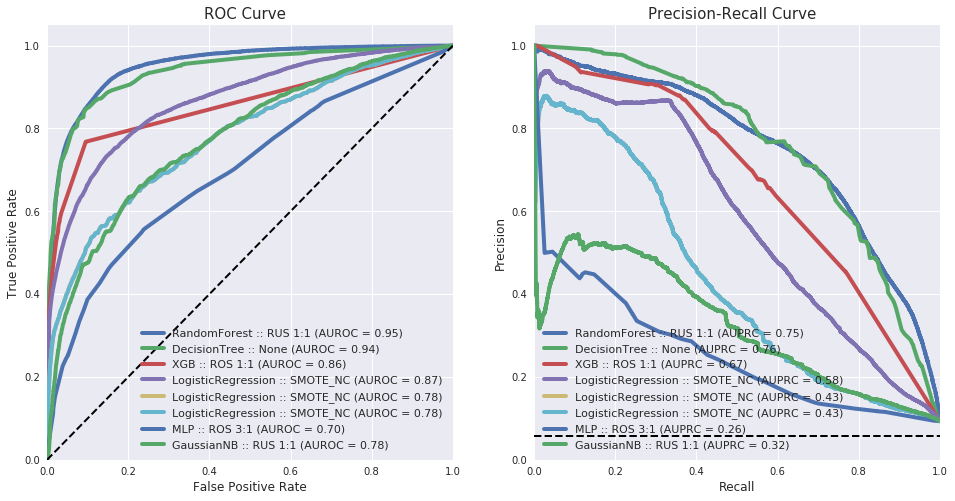

In [12]:
print("Getting best results by classifier based on {} / ordered ascending? {}".format(measure_by, measure_by_sort))
plot_results = exp_metrics.sort_values(measure_by, ascending=measure_by_sort).groupby('classifier').head(1)
plot_data = filter_top_model_results(plot_results, exp_results)
plot_roc_prc(plot_data, ' ')

### Choosing the best model and appending to overall .... 

In [ ]:
exp1_1 = load_results('/home/dissertation/code/RESULTS_FINAL/Basic_DefaultHyper_2019-08-12.pickle')
exp_metrics, exp_results = rebuild_results(exp1_1)
manualgrid = load_results('Manual_GridSearch_2019-08-05.pickle')

manualrdm = load_results('Manual_RdmSearch_2019-08-05.pickle')

In [ ]:
top_models = pd.DataFrame()

In [ ]:
top_models = top_models.append(exp_metrics.sort_values(measure_by, ascending=measure_by_sort).head(1))

In [ ]:
#filter_top_model_results(exp_metrics.sort_values(measure_by, ascending=measure_by_sort).head(1), exp_results)

In [ ]:
from scipy import stats
import scikit_posthocs as sp

xgb = plot_data[0][-2]
rf = plot_data[1][-2]
dt = plot_data[2][-2]
gnb = plot_data[3][-2]
lr = plot_data[4][-2]
mlp = plot_data[5][-2]

data = [xgb, rf, dt, gnb, lr, mlp]

stats.kruskal(*data)

In [ ]:
sp.posthoc_conover(data)

In [ ]:
#all_metrics[all_metrics.recall < 1.0].sort_values(['recall'], ascending=[False])

In [ ]:
#all_metrics.sort_values(['recall','precision'], ascending=[False, False])

In [ ]:
print(top_results.to_latex(index=False)) # doctest: +NORMALIZE_WHITESPACE

In [ ]:
import scipy.stats as ss
import statsmodels.api as sa
import scikit_posthocs as sp
import statsmodels.formula.api as sfa

df = sa.datasets.get_rdataset('iris').data
data = [df.loc[ids, 'Sepal.Width'].values for ids in df.groupby('Species').groups.values()]

In [ ]:
H, p = ss.kruskal(*data)
print(H, p)

In [ ]:
sp.posthoc_conover(df, val_col='Sepal.Width', group_col='Species', p_adjust = 'holm')

In [ ]:
df.columns = ['Sepal_Length', 'Sepal_Width', 'Petal_Length', 'Petal_Width', 'Species']

In [ ]:
lm = sfa.ols('Sepal_Width ~ C(Species)', data=df).fit()
anova = sa.stats.anova_lm(lm)
print(anova)

In [ ]:
sp.posthoc_ttest(df, val_col='Sepal_Width', group_col='Species', p_adjust='holm')